attempt of making a calibration plot

In [1]:
import pandas as pd
import numpy as np
import json
import os
import datasets
import utils
import torch
import models
import ml_insights as mli
import matplotlib.pyplot as plt

/Users/filipdorm/opt/anaconda3/envs/sinr_icml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
HIGH_RES = True
THRESHOLD = 0.5
DISABLE_OCEAN_MASK = False
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TAXA = 13270
SET_MAX_CMAP_TO_1 = False

In [3]:
# load model
train_params = torch.load('./pretrained_models/model_an_full_input_enc_sin_cos_hard_cap_num_per_class_1000.pt', map_location='cpu')
model = models.get_model(train_params['params'])
model.load_state_dict(train_params['state_dict'], strict=True)
model = model.to(DEVICE)
model.eval()

ResidualFCNet(
  (class_emb): Linear(in_features=256, out_features=47375, bias=False)
  (feats): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=

In [4]:
#load reference from iucn
with open(os.path.join('./data/eval/iucn/', 'iucn_res_5.json'), 'r') as f:
            data = json.load(f)

In [5]:
if train_params['params']['input_enc'] in ['env', 'sin_cos_env']:
    raster = datasets.load_env()
else:
    raster = None
enc = utils.CoordEncoder(train_params['params']['input_enc'], raster=raster)

In [6]:
obs_locs = np.array(data['locs'], dtype=np.float32)
obs_locs = torch.from_numpy(obs_locs).to('cpu')
loc_feat = enc.encode(obs_locs)

In [7]:
loc_feat.shape

torch.Size([2016842, 4])

In [8]:
class_of_interest = train_params['params']['class_to_taxa'].index(TAXA)

In [9]:
# make prediction
with torch.no_grad():
    preds = model(loc_feat, return_feats=False, class_of_interest=class_of_interest).cpu().numpy()

In [94]:
copy_preds = preds.copy()

In [11]:
np.mean(copy_preds)

0.003350218

In [12]:
species_locs = data['taxa_presence'].get(str(TAXA))

In [13]:
loc_feat

tensor([[-0.4897,  0.8307, -0.8719,  0.5566],
        [-0.6273,  0.9677, -0.7788,  0.2521],
        [-0.6769,  0.9661, -0.7361,  0.2583],
        ...,
        [-0.2567,  0.4512,  0.9665, -0.8924],
        [-0.5892,  0.7716,  0.8080, -0.6361],
        [-0.5621,  0.6373,  0.8271, -0.7706]])

In [14]:
truth_array = np.zeros(copy_preds.shape, int)
truth_array[species_locs] = 1

In [15]:
truth_array.shape

(2016842,)

In [16]:
preds.shape

(2016842,)

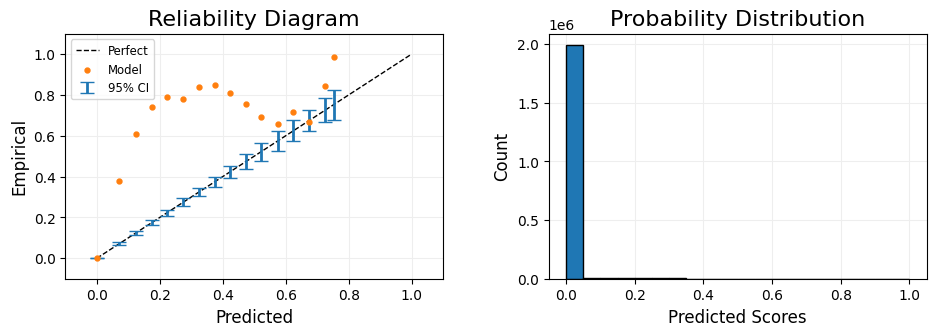

In [17]:
fig, ax = plt.subplots(figsize=(10,4))
rd = mli.plot_reliability_diagram(truth_array, preds, marker='.', show_histogram=True)

In [22]:
import geopandas as gpd
df = gpd.read_file('./continent-poly/North America.shp')



In [31]:
test = np.array(data['locs'])
plot_array = test[species_locs]

In [37]:
plot_array

array([[-98.88773346,  25.9771862 ],
       [-98.26985931,  31.33932304],
       [-99.63832092,  23.95809746],
       ...,
       [-79.79305267,  34.68382263],
       [-81.30400085,  47.18034363],
       [-71.67185974,  41.93505478]])

In [88]:
thresholds = [0.02,0.1,0.5]

In [95]:
mask1 = copy_preds>thresholds[0]
plot_threhs1 = test[mask1]

mask2 = copy_preds>thresholds[1]
plot_threhs2 = test[mask2]

mask3 = copy_preds>thresholds[2]
plot_threhs3 = test[mask3]

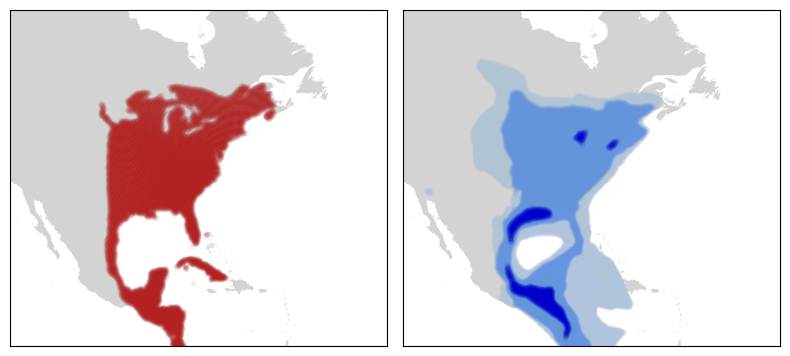

In [102]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))
#iucn map
df.plot(ax=ax1,color="lightgray")
ax1.set_xlim(-120, -40)
ax1.set_ylim(10, 60)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.scatter(plot_array[:,0], plot_array[:,1], color='firebrick', s=10, alpha=0.05)

#predictions
df.plot(ax=ax2,color="lightgray")
ax2.set_xlim(-120, -40)
ax2.set_ylim(10, 60)
ax2.set_xticks([])
ax2.set_yticks([])

ax2.scatter(plot_threhs1[:,0], plot_threhs1[:,1], color='lightsteelblue', s=10, alpha=0.05)
ax2.scatter(plot_threhs2[:,0], plot_threhs2[:,1], color='cornflowerblue', s=10, alpha=0.05)
ax2.scatter(plot_threhs3[:,0], plot_threhs3[:,1], color='mediumblue', s=10, alpha=0.05)

plt.tight_layout()
plt.show()